# Credit Approval Tutorial
This tutorial illustrates the use of several methods in the AI Explainability 360 Toolkit  to provide different kinds of explanations suited to different users in the context of a credit approval process enabled by machine learning. We use data from the [FICO Explainable Machine Learning Challenge](https://community.fico.com/s/explainable-machine-learning-challenge) as [described below](#intro). The three types of users (a.k.a. consumers) that we consider are a data scientist, who evaluates the machine learning model before deployment, a loan officer, who makes the final decision based on the model's output, and a bank customer, who wants to understand the reasons for their application result. 

For the [bank customer](#contrastive), we consider the Contrastive Explanations Method (CEM, class `CEMExplainer`) for explaining the predictions of black box models to end users. CEM builds upon the popular approach of highlighting features present in the input instance that are responsible for the model's classification. In addition to these, CEM also identifies features that are (minimally) absent in the input instance, but whose presence would have altered the classification.

The tutorial is organized around these three types of consumers, following an introduction to the dataset.
1. [Introduction to FICO HELOC Dataset](#intro)
4. [Customer: Contrastive Explanations for predictions based on HELOC Dataset](#contrastive)

<a name="intro"></a>
## 1. Introduction to FICO HELOC Dataset

The FICO HELOC dataset contains anonymized information about home equity line of credit (HELOC) applications made by real homeowners. A HELOC is a line of credit typically offered by a US bank as a percentage of home equity (the difference between the current market value of a home and the outstanding balance of all liens, e.g. mortgages). The customers in this dataset have requested a credit line in the range of USD 5,000 - 150,000. The machine learning task we are considering is to use the information about the applicant in their credit report to predict whether they will make timely payments over a two year period. The machine learning prediction can then be used to decide whether the homeowner qualifies for a line of credit and, if so, how much credit should be extended. 

The HELOC dataset and more information about it, including instructions to download, can be found [here](https://community.fico.com/s/explainable-machine-learning-challenge?tabset-3158a=2).

The table below reproduces part of the data dictionary that comes with the HELOC dataset, explaining the predictor variables and target variable. For example, NumSatisfactoryTrades is a predictor variable that counts the number of past credit agreements with the applicant, which resulted in on-time payments. The target variable to predict is a binary variable called RiskPerformance. The value “Bad” indicates that an applicant was 90 days past due or worse at least once over a period of 24 months from when the credit account was opened. The value “Good” indicates that they have made their payments without ever being more than 90 days overdue. The relationship between a predictor variable and the target is indicated in the last column of the table. If a predictor variable is monotonically decreasing with respect to probability of bad = 1, it 
means that as the value of the variable increases, the probability of the loan application being "Bad" decreases, i.e. it becomes more "good". For example, ExternalRiskEstimate and NumSatisfactoryTrades are shown as monotonically decreasing. Monotonically increasing has the opposite meaning.


|Field | Meaning |Monotonicity Constraint (with respect to probability of bad = 1)|
|------|---------|----------------------------------------------------------------|
|ExternalRiskEstimate |	Consolidated version of risk markers |Monotonically Decreasing| 
|MSinceOldestTradeOpen	| Months Since Oldest Trade Open | Monotonically Decreasing|
|MSinceMostRecentTradeOpen | Months Since Most Recent Trade Open |Monotonically Decreasing
|AverageMInFile	| Average Months in File |Monotonically Decreasing|
|NumSatisfactoryTrades |	Number Satisfactory Trades |Monotonically Decreasing|
|NumTrades60Ever2DerogPubRec |	Number Trades 60+ Ever |Monotonically Decreasing|
|NumTrades90Ever2DerogPubRec | Number Trades 90+ Ever |Monotonically Decreasing| 
|PercentTradesNeverDelq	| Percent Trades Never Delinquent|Monotonically Decreasing|
|MSinceMostRecentDelq	| Months Since Most Recent Delinquency|Monotonically Decreasing|
|MaxDelq2PublicRecLast12M |	Max Delq/Public Records Last 12 Months. See tab "MaxDelq" for each category|Values 0-7 are monotonically decreasing|
|MaxDelqEver |	Max Delinquency Ever. See tab "MaxDelq" for each category|Values 2-8 are monotonically decreasing|
|NumTotalTrades	| Number of Total Trades (total number of credit accounts)|No constraint|
|NumTradesOpeninLast12M	| Number of Trades Open in Last 12 Months|Monotonically Increasing| 
|PercentInstallTrades	| Percent Installment Trades|No constraint|
|MSinceMostRecentInqexcl7days |	Months Since Most Recent Inq excl 7days|Monotonically Decreasing| 
|NumInqLast6M	| Number of Inq Last 6 Months|Monotonically Increasing|
|NumInqLast6Mexcl7days	| Number of Inq Last 6 Months excl 7days. Excluding the last 7 days removes inquiries that are likely due to price comparision shopping. |Monotonically Increasing|
|NetFractionRevolvingBurden	| Net Fraction Revolving Burden. This is revolving balance divided by credit limit |Monotonically Increasing|
|NetFractionInstallBurden	| Net Fraction Installment Burden. This is installment balance divided by original loan amount |Monotonically Increasing| 
|NumRevolvingTradesWBalance	| Number Revolving Trades with Balance |No constraint|
|NumInstallTradesWBalance	| Number Installment Trades with Balance |No constraint|
|NumBank2NatlTradesWHighUtilization	| Number Bank/Natl Trades w high utilization ratio |Monotonically Increasing|
|PercentTradesWBalance	| Percent Trades with Balance |No constraint
|RiskPerformance	| Paid as negotiated flag (12-36 Months). String of Good and Bad | Target |


#### Storing HELOC dataset to run this notebook
- In this notebook, we assume that the HELOC dataset is saved as `./aix360/data/heloc_data/heloc_dataset.csv`, where "." is the root directory of the Git repository before running a pip install of aix360 library. 
- If the data is downloaded after installation, please place the file within the respective folder under site-packages of your virtual environment `path-to-your-virtual-env/lib/python3.6/site-packages/aix360/data/heloc_data/heloc_dataset.csv`


<a name="contrastive"></a>
## 1. Customer: Contrastive explanations for HELOC Use Case

We now demonstrate how to compute contrastive explanations using AIX360 and how such explanations can help home owners understand the decisions made by AI models that approve or reject their HELOC applications. 

Typically, home owners would like to understand why they do not qualify for a line of credit and if so what changes in their application would qualify them. On the other hand, if they qualified, they might want to know what factors led to the approval of their application. 

In this context, contrastive explanations provide information to applicants about what minimal changes to their profile would have changed the decision of the AI model from reject to accept or vice-versa (_pertinent negatives_). For example, increasing the number of satisfactory trades to a certain value may have led to the acceptance of the application everything else being the same. 

The method presented here also highlights a minimal set of features and their values that would still maintain the original decision (_pertinent positives_). For example, for an applicant whose HELOC application was approved, the 
explanation may say that even if the number of satisfactory trades was reduced to a lower number, the loan would have still gotten through.

Additionally, organizations (Banks, financial institutions, etc.) would like to understand trends in the behavior of their AI models in approving loan applications, which could be done by studying contrastive explanations for individuals whose loans were either accepted or rejected. Looking at the aggregate statistics of pertinent positives for approved applicants the organization can get insight into what minimal set of features and their values play an important role in acceptances. While studying the aggregate statistics of pertinent negatives the organization can get insight into features that could change the status of rejected applicants and potentially uncover ways that an applicant may game the system by changing potentially non-important features that could alter the models outcome. 

The contrastive explanations in AIX360 are implemented using the algorithm developed in the following work:
###### [Explanations based on the Missing: Towards Contrastive Explanations with Pertinent Negatives](https://arxiv.org/abs/1802.07623)

We now provide a brief overview of the method. As mentioned above the algorithm outputs a contrastive explanation which consists of two parts: a) pertinent negatives (PNs) and b) pertinent positives (PPs). PNs identify a minimal set of features which if altered would change the classification of the original input. For example, in the loan case if a person's credit score is increased their loan application status may change from reject to accept. The manner in which the method accomplishes this is by optimizing a change in the prediction probability loss while enforcing an elastic norm constraint that results in minimal change of features and their values. Optionally, an auto-encoder may also be used to force these minimal changes to produce realistic PNs. PPs on the other hand identify a minimal set of features and their values that are sufficient to yield the original input's classification. For example, an individual's loan may still be accepted if the salary was 50K as opposed to 100K. Here again we have an elastic norm term so that the amount of information needed is minimal, however, the first loss term in this case tries to make the original input's class to be the winning class. For a more in-depth discussion, please refer to the above work.


The three main steps to obtain a contrastive explanation are shown below. The first two steps are more about processing the data and building an AI model while the third step computes the actual explanation. 

 [Step 1. Process and Normalize HELOC dataset for training](#c1)<br>
 [Step 2. Define and train a NN classifier](#c2)<br>
 [Step 3. Compute contrastive explanations for a few applicants](#c3)<br>


### Load HELOC dataset and show sample applicants

In [6]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
heloc = HELOCDataset()
df = heloc.dataframe()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 24)
pd.set_option('display.width', 1000)
print("Size of HELOC dataset:", df.shape)
print("Number of \"Good\" applicants:", np.sum(df['RiskPerformance']=='Good'))
print("Number of \"Bad\" applicants:", np.sum(df['RiskPerformance']=='Bad'))
print("Sample Applicants:")
df.head(10).transpose()

Using Heloc dataset:  /home/yongjie/software/AIX360/aix360/datasets/../data/heloc_data/heloc_dataset.csv
Size of HELOC dataset: (10459, 24)
Number of "Good" applicants: 5000
Number of "Bad" applicants: 5459
Sample Applicants:


,0,1,2,3,4,5,6,7,8,9
ExternalRiskEstimate,55,61,67,66,81,59,54,68,59,61
MSinceOldestTradeOpen,144,58,66,169,333,137,88,148,324,79
MSinceMostRecentTradeOpen,4,15,5,1,27,11,7,7,2,4
AverageMInFile,84,41,24,73,132,78,37,65,138,36
NumSatisfactoryTrades,20,2,9,28,12,31,25,17,24,19
NumTrades60Ever2DerogPubRec,3,4,0,1,0,0,0,0,0,0
NumTrades90Ever2DerogPubRec,0,4,0,1,0,0,0,0,0,0
PercentTradesNeverDelq,83,100,100,93,100,91,92,83,85,95
MSinceMostRecentDelq,2,-7,-7,76,-7,1,9,31,5,5
MaxDelq2PublicRecLast12M,3,0,7,6,7,4,4,6,4,4


Distribution of ExternalRiskEstimate and NumSatisfactoryTrades columns:


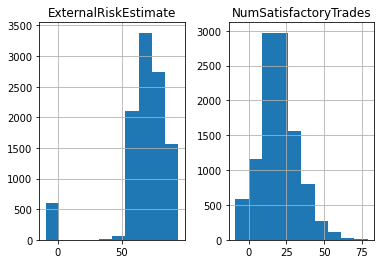

In [7]:
# Plot (example) distributions for two features
print("Distribution of ExternalRiskEstimate and NumSatisfactoryTrades columns:")
hist = df.hist(column=['ExternalRiskEstimate', 'NumSatisfactoryTrades'], bins=10)

<a name="c1"></a>
### Step 1. Process and Normalize HELOC dataset for training

We will first process the HELOC dataset before using it to train an NN model that can predict the
target variable RiskPerformance. The HELOC dataset is a tabular dataset with numerical values. However, some of the values are negative and need to be filtered. The processed data is stored in the file heloc.npz for easy access. The dataset is also normalized for training.

The data processing and model building is very similar to the Loan Officer persona above, where ProtoDash was the method of choice. We repeat these steps here so that both the use cases can be run independently.

#### a. Process the dataset

In [9]:
# Clean data and split dataset into train/test
PROCESS_DATA = True

if (PROCESS_DATA): 
    (Data, x_train, x_test, y_train_b, y_test_b) = heloc.split()
    np.savez('heloc.npz', Data=Data, x_train=x_train, x_test=x_test, y_train_b=y_train_b, y_test_b=y_test_b)
else:
    heloc = np.load('heloc.npz', allow_pickle = True)
    Data = heloc['Data']
    x_train = heloc['x_train']
    x_test  = heloc['x_test']
    y_train_b = heloc['y_train_b']
    y_test_b  = heloc['y_test_b']



#### b. Normalize the dataset

In [10]:
Z = np.vstack((x_train, x_test))
Zmax = np.max(Z, axis=0)
Zmin = np.min(Z, axis=0)

#normalize an array of samples to range [-0.5, 0.5]
def normalize(V):
    VN = (V - Zmin)/(Zmax - Zmin)
    VN = VN - 0.5
    return(VN)
    
# rescale a sample to recover original values for normalized values. 
def rescale(X):
    return(np.multiply ( X + 0.5, (Zmax - Zmin) ) + Zmin)

N = normalize(Z)
xn_train = N[0:x_train.shape[0], :]
xn_test  = N[x_train.shape[0]:, :]

<a name="c2"></a>
### Step 2. Define and train a NN classifier

Let us now build a loan approval model based on the HELOC dataset.

#### a. Define NN architecture
We now define the architecture of a 2-layer neural network classifier whose predictions we will try to interpret. 

In [11]:
# nn with no softmax
def nn_small():
    model = Sequential()
    model.add(Dense(10, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))    
    return model

#### b. Train the NN

In [18]:
# Set random seeds for repeatability
import tensorflow as tf
np.random.seed(1) 
tf.set_random_seed(2) 

class_names = ['Bad', 'Good']

# loss function
def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted)

# compile and print model summary
nn = nn_small()
nn.compile(loss=fn, optimizer='adam', metrics=['accuracy'])
nn.summary()


# train model or load a trained model
TRAIN_MODEL = True

if (TRAIN_MODEL):             
    nn.fit(xn_train, y_train_b, batch_size=128, epochs=500, verbose=1, shuffle=False)
    nn.save_weights("heloc_nnsmall.h5")     
else:    
    nn.load_weights("heloc_nnsmall.h5")
        

# evaluate model accuracy        
score = nn.evaluate(xn_train, y_train_b, verbose=0) #Compute training set accuracy
#print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = nn.evaluate(xn_test, y_test_b, verbose=0) #Compute test set accuracy
#print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                240       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 22        
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
7403/7403 [==============================] - 0s 26us/step - loss: 0.6878 - accuracy: 0.5345
Epoch 2/500
7403/7403 [==============================] - 0s 11us/step - loss: 0.6640 - accuracy: 0.6416
Epoch 3/500
7403/7403 [==============================] - 0s 12us/step - loss: 0.6243 - accuracy: 0.6994
Epoch 4/500
7403/7403 [==============================] - 0s 11us/step - loss: 0.5930 - accuracy: 0.7096
Epoch 5/500
7403/7403 [==============================] - 0s 11us/step - loss: 0.5765 - accuracy: 0.713

7403/7403 [==============================] - 0s 9us/step - loss: 0.5410 - accuracy: 0.7347
Epoch 74/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5409 - accuracy: 0.7346
Epoch 75/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5409 - accuracy: 0.7343
Epoch 76/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5408 - accuracy: 0.7338
Epoch 77/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5407 - accuracy: 0.7335
Epoch 78/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5407 - accuracy: 0.7334
Epoch 79/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5406 - accuracy: 0.7336
Epoch 80/500
7403/7403 [==============================] - 0s 11us/step - loss: 0.5406 - accuracy: 0.7335
Epoch 81/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5405 - accuracy: 0.7338
Epoch 82/500
7403/7403 [==============================] - 0s 11us/step - lo

7403/7403 [==============================] - 0s 11us/step - loss: 0.5372 - accuracy: 0.7348
Epoch 152/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5372 - accuracy: 0.7347
Epoch 153/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5371 - accuracy: 0.7344
Epoch 154/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5371 - accuracy: 0.7343
Epoch 155/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5370 - accuracy: 0.7347
Epoch 156/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5370 - accuracy: 0.7350
Epoch 157/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5370 - accuracy: 0.7348
Epoch 158/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5370 - accuracy: 0.7347
Epoch 159/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5369 - accuracy: 0.7350
Epoch 160/500
7403/7403 [==============================] - 0s 9us/st

Epoch 229/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5358 - accuracy: 0.7347
Epoch 230/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5357 - accuracy: 0.7346
Epoch 231/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5357 - accuracy: 0.7347
Epoch 232/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5357 - accuracy: 0.7350
Epoch 233/500
7403/7403 [==============================] - 0s 12us/step - loss: 0.5357 - accuracy: 0.7350
Epoch 234/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5357 - accuracy: 0.7351
Epoch 235/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5357 - accuracy: 0.7351
Epoch 236/500
7403/7403 [==============================] - 0s 8us/step - loss: 0.5357 - accuracy: 0.7351
Epoch 237/500
7403/7403 [==============================] - 0s 8us/step - loss: 0.5357 - accuracy: 0.7348
Epoch 238/500
7403/7403 [============================

7403/7403 [==============================] - 0s 10us/step - loss: 0.5327 - accuracy: 0.7374
Epoch 307/500
7403/7403 [==============================] - 0s 11us/step - loss: 0.5327 - accuracy: 0.7374
Epoch 308/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5327 - accuracy: 0.7370
Epoch 309/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5326 - accuracy: 0.7371
Epoch 310/500
7403/7403 [==============================] - 0s 12us/step - loss: 0.5326 - accuracy: 0.7374
Epoch 311/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5326 - accuracy: 0.7374
Epoch 312/500
7403/7403 [==============================] - 0s 12us/step - loss: 0.5326 - accuracy: 0.7373
Epoch 313/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5325 - accuracy: 0.7370
Epoch 314/500
7403/7403 [==============================] - 0s 11us/step - loss: 0.5325 - accuracy: 0.7370
Epoch 315/500
7403/7403 [==============================] - 0

7403/7403 [==============================] - 0s 10us/step - loss: 0.5311 - accuracy: 0.7366
Epoch 384/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5311 - accuracy: 0.7366
Epoch 385/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5311 - accuracy: 0.7366
Epoch 386/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5311 - accuracy: 0.7365
Epoch 387/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5310 - accuracy: 0.7367
Epoch 388/500
7403/7403 [==============================] - 0s 13us/step - loss: 0.5310 - accuracy: 0.7366
Epoch 389/500
7403/7403 [==============================] - 0s 11us/step - loss: 0.5310 - accuracy: 0.7363
Epoch 390/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5310 - accuracy: 0.7365
Epoch 391/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5310 - accuracy: 0.7363
Epoch 392/500
7403/7403 [==============================] - 0s 10u

7403/7403 [==============================] - 0s 10us/step - loss: 0.5303 - accuracy: 0.7361
Epoch 461/500
7403/7403 [==============================] - 0s 11us/step - loss: 0.5303 - accuracy: 0.7365
Epoch 462/500
7403/7403 [==============================] - 0s 11us/step - loss: 0.5303 - accuracy: 0.7363
Epoch 463/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5303 - accuracy: 0.7361
Epoch 464/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5303 - accuracy: 0.7361
Epoch 465/500
7403/7403 [==============================] - 0s 12us/step - loss: 0.5303 - accuracy: 0.7363
Epoch 466/500
7403/7403 [==============================] - 0s 11us/step - loss: 0.5303 - accuracy: 0.7363
Epoch 467/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5303 - accuracy: 0.7361
Epoch 468/500
7403/7403 [==============================] - 0s 11us/step - loss: 0.5303 - accuracy: 0.7361
Epoch 469/500
7403/7403 [==============================] - 0

<a name="c3"></a>
### Step 3. Compute contrastive explanations for a few applicants

Given the trained NN model to decide on loan approvals, let us first examine an applicant whose application was denied and what (minimal) changes to his/her application would lead to approval (i.e. finding pertinent negatives). We will then look at another applicant whose loan was approved and ascertain features that would minimally suffice in him/her still getting a positive outcome (i.e. finding pertinent positives).

#### a. Compute Pertinent Negatives (PN): 

In order to compute pertinent negatives, the CEM explainer computes a user profile that is close to the original applicant but for whom the decision of HELOC application is different. The explainer alters a minimal set of features by a minimal (positive) amount. This will help the user whose loan application was initially rejected say, to ascertain how to get it accepted. 

In [19]:
# Some interesting user samples to try: 2344 449 1168 1272
idx = 1272

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)
print("Computing PN for Sample:", idx)
print("Prediction made by the model:", nn.predict_proba(X))
print("Prediction probabilities:", class_names[np.argmax(nn.predict_proba(X))])
print("")

mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PN' # Find pertinent negatives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.2 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1e-1 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder
arg_alpha = 0.01 # Penalizes L2 norm of the solution
arg_threshold = 1. # Automatically turn off features <= arg_threshold if arg_threshold < 1
arg_offset = 0.5 # the model assumes classifier trained on data normalized
                # in [-arg_offset, arg_offset] range, where arg_offset is 0 or 0.5
# Find PN for applicant 1272
(adv_pn, delta_pn, info_pn) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma,
                                                            arg_alpha, arg_threshold, arg_offset)


Computing PN for Sample: 1272
Prediction made by the model: [[ 0.40490627 -0.39735   ]]
Prediction probabilities: Bad




Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

iter:0 const:[10.]
Loss_Overall:0.2899, Loss_Attack:0.0000
Loss_L2Dist:0.2041, Loss_L1Dist:0.8581, AE_loss:0.0
target_lab_score:-1.1540, max_nontarget_lab_score:1.3097

iter:500 const:[10.]
Loss_Overall:0.1668, Loss_Attack:0.0000
Loss_L2Dist:0.1123, Loss_L1Dist:0.5442, AE_loss:0.0
target_lab_score:-0.7192, max_nontarget_lab_score:0.8370

iter:0 const:[5.]
Loss_Overall:0.0659, Loss_Attack:0.0000
Loss_L2Dist:0.0362, Loss_L1Dist:0.2970, AE_loss:0.0
target_lab_score:-0.2231, max_nontarget_lab_score:0.2926

iter:500 const:[5.]
Loss_Overall:0.0618, Loss_Attack:0.0000
Loss_L2Dist:0.0346, Loss_L1Dist:0.2722, AE_loss:0.0
target_lab_score:-0.1894, max_nontarget_lab_score:0.2556

iter:0 const:[2.5]
Loss_Ov

In [27]:
adv_pn.shape

(1, 23)

Let us start by examining one particular loan application that was denied for applicant 1272. We showcase below how the decision could have been different through minimal changes to the profile conveyed by the pertinent negative. We also indicate the importance of different features to produce the change in the application status. The column delta in the table below indicates the necessary deviations for each of the features to produce this change. A human friendly explanation is then provided based on these deviations following the feature importance plot.

In [20]:
Xpn = adv_pn
classes = [ class_names[np.argmax(nn.predict_proba(X))], class_names[np.argmax(nn.predict_proba(Xpn))], 'NIL' ]

print("Sample:", idx)
print("prediction(X)", nn.predict_proba(X), class_names[np.argmax(nn.predict_proba(X))])
print("prediction(Xpn)", nn.predict_proba(Xpn), class_names[np.argmax(nn.predict_proba(Xpn))] )


X_re = rescale(X) # Convert values back to original scale from normalized
Xpn_re = rescale(Xpn)
Xpn_re = np.around(Xpn_re.astype(np.double), 2)

delta_re = Xpn_re - X_re
delta_re = np.around(delta_re.astype(np.double), 2)
delta_re[np.absolute(delta_re) < 1e-4] = 0

X3 = np.vstack((X_re, Xpn_re, delta_re))

dfre = pd.DataFrame.from_records(X3) # Create dataframe to display original point, PN and difference (delta)
dfre[23] = classes

dfre.columns = df.columns
dfre.rename(index={0:'X',1:'X_PN', 2:'(X_PN - X)'}, inplace=True)
dfret = dfre.transpose()


def highlight_ce(s, col, ncols):
    if (type(s[col]) != str):
        if (s[col] > 0):
            return(['background-color: yellow']*ncols)    
    return(['background-color: white']*ncols)

dfret.style.apply(highlight_ce, col='(X_PN - X)', ncols=3, axis=1) 

Sample: 1272
prediction(X) [[ 0.40490627 -0.39735   ]] Bad
prediction(Xpn) [[-0.17214072  0.23658839]] Good


,X,X_PN,(X_PN - X)
ExternalRiskEstimate,65.000000,80.630000,15.630000
MSinceOldestTradeOpen,256.000000,256.000000,0.000000
MSinceMostRecentTradeOpen,15.000000,15.000000,0.000000
AverageMInFile,52.000000,66.280000,14.280000
NumSatisfactoryTrades,17.000000,21.750000,4.750000
NumTrades60Ever2DerogPubRec,0.000000,0.000000,0.000000
NumTrades90Ever2DerogPubRec,0.000000,0.000000,0.000000
PercentTradesNeverDelq,100.000000,100.000000,0.000000
MSinceMostRecentDelq,0.000000,0.000000,0.000000
MaxDelq2PublicRecLast12M,7.000000,7.000000,0.000000


Now let us compute the importance of different PN features that would be instrumental in 1272 receiving a favorable outcome and display below.

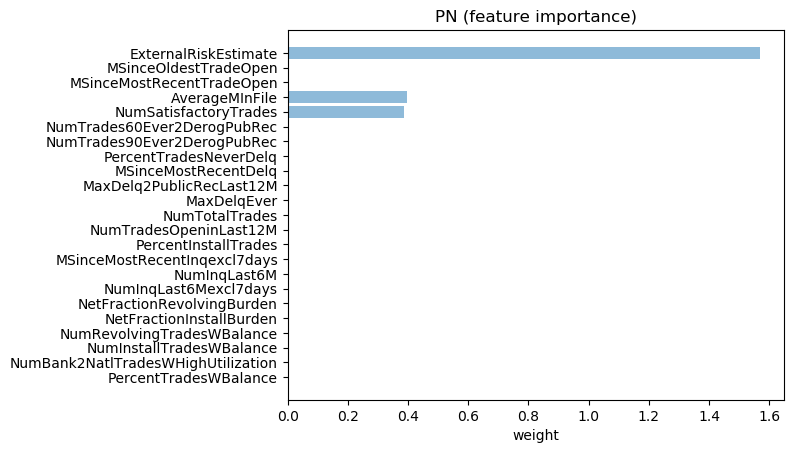

In [45]:
plt.rcdefaults()
fi = abs((X-Xpn).astype('double'))/np.std(xn_train.astype('double'), axis=0) # Compute PN feature importance
objects = df.columns[-2::-1]
y_pos = np.arange(len(objects))
performance = fi[0, -1::-1]

plt.barh(y_pos, performance, align='center', alpha=0.5) # bar chart
plt.yticks(y_pos, objects) # Display features on y-axis
plt.xlabel('weight') # x-label
plt.title('PN (feature importance)') # Heading 

plt.show() # Display PN feature importance

#### Explanation:  
We observe that the applicant 1272's loan application would have been accepted if the consolidated risk marker score  (i.e. ExternalRiskEstimate) increased from 65 to 81, the loan application was on file (i.e. AverageMlnFile) for about 66 months and if the number of satisfactory trades (i.e. NumSatisfactoryTrades) increased to little over 21.

_The above changes to the three suggested factors are also intuitively consistent in improving the chances of acceptance of an application, since all three are monotonic with probability of acceptance (refer HELOC description table). 
However, one must realize that the above explanation is for the particular applicant based on what the model would do and does not necessarily have to agree with their intuitive meaning. In fact, if the explanation is deemed unacceptable then its an indication that perhaps the model should be debugged/updated_.

#### Compute Pertinent Positives (PP):
In order to compute pertinent positives, the CEM explainer identifies a minimal set of features along with their values (as close to 0) that would still maintain the predicted loan application status of the applicant.

In [46]:
# Some interesting user samples to try: 9 11 24
idx = 9

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)
print("Computing PP for Sample:", idx)
print("Prediction made by the model:", class_names[np.argmax(nn.predict_proba(X))])
print("Prediction probabilities:", nn.predict_proba(X))
print("")


mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PP' # Find pertinent positives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.2 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 10.0 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder
arg_alpha = 0.1 # Penalizes L2 norm of the solution
arg_threshold = 0.0 # Automatically turn off features <= arg_threshold if arg_threshold < 1
arg_offset = 0.5 # the model assumes classifier trained on data normalized
                # in [-arg_offset, arg_offset] range, where arg_offset is 0 or 0.5
(adv_pp, delta_pp, info_pp) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma,
                                                            arg_alpha, arg_threshold, arg_offset)

Computing PP for Sample: 9
Prediction made by the model: Good
Prediction probabilities: [[-0.4284743  0.5507633]]

iter:0 const:[10.]
Loss_Overall:46.4647, Loss_Attack:46.4647
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:-2.3206, max_nontarget_lab_score:2.1259

iter:500 const:[10.]
Loss_Overall:46.4647, Loss_Attack:46.4647
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:-2.3206, max_nontarget_lab_score:2.1259

iter:0 const:[100.]
Loss_Overall:464.6470, Loss_Attack:464.6470
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:-2.3206, max_nontarget_lab_score:2.1259

iter:500 const:[100.]
Loss_Overall:464.6470, Loss_Attack:464.6470
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:-2.3206, max_nontarget_lab_score:2.1259

iter:0 const:[1000.]
Loss_Overall:1009.1559, Loss_Attack:990.0610
Loss_L2Dist:1.3315, Loss_L1Dist:1.7763, AE_loss:0.0
target_lab_score:-0.3720, max_nontarget_lab_score:0.4181

iter:500 const:

For the pertinent positives, we look at a different applicant 8 whose loan application was approved. We want to ascertain here what minimal values for this profile would still have lead to acceptance. Below, we showcase the pertinent positive as well as the important features in maintaining the approved status. The 0s in the PP column indicate that those features were not important. The 0s in the PP column indicate that those features were not important. Here too, we provide a human friendly explanation following the feature importance plot.

In [47]:
Xpp = delta_pp
classes = [ class_names[np.argmax(nn.predict_proba(X))], class_names[np.argmax(nn.predict_proba(Xpp))]]

print("PP for Sample:", idx)
print("Prediction(Xpp) :", class_names[np.argmax(nn.predict_proba(Xpp))])
print("Prediction probabilities for Xpp:", nn.predict_proba(Xpp))
print("")

X_re = rescale(X) # Convert values back to original scale from normalized
adv_pp_re = rescale(adv_pp)
#Xpp_re = X_re - adv_pp_re
Xpp_re = rescale(Xpp)
Xpp_re = np.around(Xpp_re.astype(np.double), 2)
Xpp_re[Xpp_re < 1e-4] = 0

X2 = np.vstack((X_re, Xpp_re))

dfpp = pd.DataFrame.from_records(X2.astype('double')) # Showcase a dataframe for the original point and PP
dfpp[23] = classes
dfpp.columns = df.columns
dfpp.rename(index={0:'X',1:'X_PP'}, inplace=True)
dfppt = dfpp.transpose()

dfppt.style.apply(highlight_ce, col='X_PP', ncols=2, axis=1) 

PP for Sample: 9
Prediction(Xpp) : Good
Prediction probabilities for Xpp: [[-0.29156655  0.3953777 ]]



,X,X_PP
ExternalRiskEstimate,74.000000,74.000000
MSinceOldestTradeOpen,181.000000,0.000000
MSinceMostRecentTradeOpen,1.000000,0.000000
AverageMInFile,65.000000,4.000000
NumSatisfactoryTrades,61.000000,61.000000
NumTrades60Ever2DerogPubRec,0.000000,0.000000
NumTrades90Ever2DerogPubRec,0.000000,0.000000
PercentTradesNeverDelq,100.000000,100.000000
MSinceMostRecentDelq,0.000000,0.000000
MaxDelq2PublicRecLast12M,6.000000,0.000000


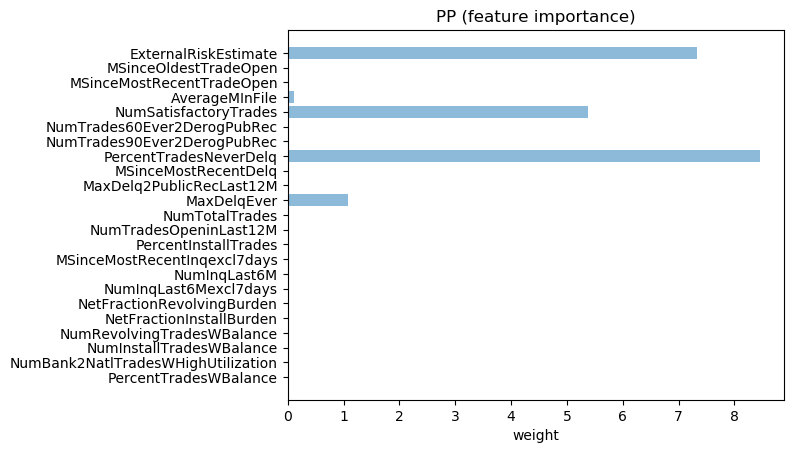

In [48]:
plt.rcdefaults()
fi = abs(Xpp_re.astype('double'))/np.std(x_train.astype('double'), axis=0) # Compute PP feature importance
    
objects = df.columns[-2::-1]
y_pos = np.arange(len(objects)) # Get input feature names
performance = fi[0, -1::-1]

plt.barh(y_pos, performance, align='center', alpha=0.5) # Bar chart
plt.yticks(y_pos, objects) # Plot feature names on y-axis
plt.xlabel('weight') #x-label
plt.title('PP (feature importance)') # Figure heading

plt.show()    # Display the feature importance

#### Explanation:  
We observe that the applicant 9's loan application would still have been accepted even if only three variables maintained their original level - the consolidated risk marker score (i.e. ExternalRiskEstimate), the number of satisfactory trades (i.e. NumSatisfactoryTrades), and the percentage of trades that were never delinquent (i.e. PercentTradesNeverDelq) - and had a significant reduction in an additional variable - average months that application was on file (i.e. AverageMlnFile). MaxDelqEver is reduced to a minimum over the data.

_Note that explanations may change a bit based on equivalent values in a local minima._